## Gaussian filter prediction with vgg19_bn

### Train part

In [1]:
from __future__ import print_function

import os
import sys
import random

import torch
import torch.utils.data as tdata
import torchvision.transforms as transforms

from PIL import Image
import numpy as np

import scipy
import scipy.ndimage

import torchvision.transforms as transforms

import torchvision
import matplotlib.pyplot as plt 

from torchvision.models import vgg19_bn

In [5]:
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()

In [6]:
class GradientImagesDataset(tdata.Dataset):
    def __init__(self, root, box_size=32):
        '''
        Args:
          root:     (str) ditectory to images.
          box_size: (int) box size.
        '''
        self.root = root
        
        self.images = []
        self.labels = []

        self.num_samples = 0
        
        for fname in os.listdir(self.root):
            fp = os.path.join(self.root, fname)
            im = Image.open(fp)   
            if im.mode != 'RGB':
                im = im.convert('RGB')

            for x in range(0, im.width, box_size):
                for y in range(0, im.height, box_size):
                    icr = im.crop(box=(x, y, x + box_size, y + box_size))
                    
                    self.images.append(np.array(icr).transpose(2,0,1)) #.transpose(2,0,1)
                    self.labels.append(0)
                    
                    icr = scipy.ndimage.gaussian_filter(icr, sigma=1)
                    self.images.append(np.array(icr).transpose(2,0,1))
                    self.labels.append(1)
                    
                    # one normal and one after gaussian filter
                    self.num_samples += 2
            
                    
    def __getitem__(self, idx):
        label = self.labels[idx]
        img = self.images[idx]
        img_as_tensor = torch.tensor(img, dtype=torch.float)
        return (img_as_tensor, label)
   
    def __len__(self):
        return self.num_samples

In [28]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [8]:
dataset = GradientImagesDataset(root='./img3', box_size=32)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)
valloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)

In [9]:
len(dataset)

125544

In [12]:
model = vgg19_bn(pretrained=False, num_classes=2)
model = model.cuda()

In [84]:
torch.cuda.empty_cache()

In [13]:
criterion2 = nn.CrossEntropyLoss().cuda()
optimizer2 = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [14]:
old_classifier = list(model.classifier.children()) # get the classifier part alone
old_classifier.pop(0) 
old_classifier.insert(0, nn.Linear(512,4096)) # add a new layer
model.classifier = nn.Sequential(*old_classifier) # attach it to the original vgg model

In [41]:
model = model.cuda()

In [16]:
import torch.nn.parallel
import torch.backends.cudnn as cudnn

In [17]:
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
cudnn.benchmark = True

In [18]:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs
        inputs, labels = data
        
        labels = labels.cuda(async=True)
        inputs_var = torch.autograd.Variable(inputs).cuda()
        labels_var = torch.autograd.Variable(labels).cuda()
        # zero the parameter gradients
        optimizer2.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs_var)
        loss = criterion2(outputs.cuda(), labels_var)
        loss.backward()
        optimizer2.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 0.392
[1,  2000] loss: 0.346
[1,  3000] loss: 0.311
[1,  4000] loss: 0.291
[1,  5000] loss: 0.259
[1,  6000] loss: 0.249
[1,  7000] loss: 0.236
[1,  8000] loss: 0.203
[1,  9000] loss: 0.193
[1, 10000] loss: 0.182
[1, 11000] loss: 0.169
[1, 12000] loss: 0.145
[1, 13000] loss: 0.122
[1, 14000] loss: 0.124
[1, 15000] loss: 0.098
[2,  1000] loss: 0.081
[2,  2000] loss: 0.083
[2,  3000] loss: 0.078
[2,  4000] loss: 0.073
[2,  5000] loss: 0.063
[2,  6000] loss: 0.061
[2,  7000] loss: 0.056
[2,  8000] loss: 0.044
[2,  9000] loss: 0.042
[2, 10000] loss: 0.038
[2, 11000] loss: 0.043
[2, 12000] loss: 0.036
[2, 13000] loss: 0.035
[2, 14000] loss: 0.035
[2, 15000] loss: 0.038
[3,  1000] loss: 0.037
[3,  2000] loss: 0.032
[3,  3000] loss: 0.034
[3,  4000] loss: 0.041
[3,  5000] loss: 0.035
[3,  6000] loss: 0.030
[3,  7000] loss: 0.050
[3,  8000] loss: 0.037
[3,  9000] loss: 0.034
[3, 10000] loss: 0.050
[3, 11000] loss: 0.040
[3, 12000] loss: 0.037
[3, 13000] loss: 0.033
[3, 14000] 

In [20]:
torch.save(model, "torch_model_vgg19bn.bin")

In [63]:
mm = torch.load("torch_model_vgg19bn.bin")

In [64]:
mm.eval()

DataParallel(
  (module): DataParallel(
    (module): VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): ReLU(inplace)
        (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (12): ReLU(inplace)
        (13): MaxPoo

In [76]:
dataiter = iter(dataloader)
images, labels = dataiter.next()

In [77]:
outputs = mm(images)

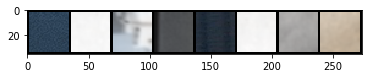

In [78]:
imshow(torchvision.utils.make_grid(images))

In [79]:
_, predicted = torch.max(outputs, 1)

print(predicted)

tensor([ 0,  1,  1,  1,  0,  1,  1,  1], device='cuda:0')


In [80]:
print(labels)

tensor([ 0,  1,  1,  1,  0,  1,  1,  1])


In [81]:
_

tensor([ 3.6586,  2.4446,  2.5021,  3.5426,  4.8445,  2.7425,  3.3651,
         3.7281], device='cuda:0')

In [71]:
path="img3/"

In [72]:
fname = "me.jpg"

In [73]:
box_size = 32

In [74]:
images = []
fp = os.path.join(path, fname)
im = Image.open(fp)   
if im.mode != 'RGB':
    im = im.convert('RGB')

for x in range(0, im.width, box_size):
    for y in range(0, im.height, box_size):
        icr = im.crop(box=(x, y, x + box_size, y + box_size))

        images.append(np.array(icr).transpose(2,0,1))

In [85]:
outp = mm(torch.tensor(images[0:7], dtype=torch.float))

RuntimeError: cuda runtime error (2) : out of memory at c:\users\administrator\downloads\new-builder\win-wheel\pytorch\aten\src\thc\generic/THCStorage.cu:58

In [59]:
_, pred = torch.max(outp, 1)

In [60]:
pred, _

(tensor([ 0,  0,  0,  0,  0,  0,  1,  1], device='cuda:0'),
 tensor([ 1.3804,  1.3577,  2.3882,  2.3150,  2.8060,  1.7898,  0.5646,
          2.6195], device='cuda:0'))

In [61]:
outp

tensor([[ 1.3804, -1.4429],
        [ 1.3577, -1.4206],
        [ 2.3882, -2.4947],
        [ 2.3150, -2.4179],
        [ 2.8060, -2.9330],
        [ 1.7898, -1.8648],
        [-0.5510,  0.5646],
        [-2.5904,  2.6195]], device='cuda:0')